# Problem Statement

#### The data involves reviews for a generic online retailer. Problem statement:
#### - Generate detailed insights that go beyond overall sentiment <br> - Identify pain points and what are working/not working for the products 

# Solution

In [127]:
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from wordcloud import WordCloud
import numpy as np
from textblob import TextBlob
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('vader_lexicon')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\mayur\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mayur\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\mayur\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [128]:
df = pd.read_csv('Raw_Reviews.csv')
df.head()

,Product_ID,Age,Title,Text_Review,Rating,Type
0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,Intimate
1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,Dresses
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,Dresses
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,Bottoms
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,Tops


In [129]:
df.dtypes

Product_ID      int64
Age             int64
Title          object
Text_Review    object
Rating          int64
Type           object
dtype: object

In [130]:
len(df)

23486

### Finding NaN entries across all columns

In [131]:
df.isna().sum()

Product_ID        0
Age               0
Title          3810
Text_Review     845
Rating            0
Type             14
dtype: int64

### Replacing NaN values for Text_Review with ' '

In [132]:
df['Text_Review'].fillna('', inplace = True)
df.isna().sum()

Product_ID        0
Age               0
Title          3810
Text_Review       0
Rating            0
Type             14
dtype: int64

### Changing dtype of Text_Review from float to str

In [133]:
df['Text_Review'] = df['Text_Review'].astype(str)

### There are 3810 NaN values for Title and 14 NaN values for Type

In [134]:
df[df['Type'].isna()]

,Product_ID,Age,Title,Text_Review,Rating,Type
9444,72,25,My favorite socks!!!,"I never write reviews, but these socks are so ...",5,NaN
13767,492,23,So soft!,I just love this hoodie! it is so soft and com...,5,NaN
13768,492,49,Wardrobe staple,Love this hoodie. so soft and goes with everyt...,5,NaN
13787,492,48,NaN,,5,NaN
16216,152,36,Warm and cozy,"Just what i was looking for. soft, cozy and warm.",5,NaN
16221,152,37,Love!,I am loving these. they are quite long but are...,5,NaN
16223,152,39,"""long and warm""",These leg warmers are perfect for me. they are...,5,NaN
18626,184,34,Nubby footless tights,"These are amazing quality. i agree, size up to...",5,NaN
18671,184,54,New workhorse,These tights are amazing! if i care for them w...,5,NaN
20088,772,50,Comfy sweatshirt!,This sweatshirt is really nice! it's oversize...,5,NaN


### We can replace some NaN values extracting clothing names from Title or Text_Review

### Constructing a mapping between item name -> item category  <br> Eg: Socks -> Intimate

### In the below cell we find the most common type for item "socks"

In [135]:
df[df['Title'].str.contains('socks', case=False, na=False)]['Type'].mode()

0    Intimate
Name: Type, dtype: object

### We search for titles that contain the term hoodie to look for corresponding most common type

In [136]:
df[df['Title'].str.contains('hoodie', case=False, na=False)]['Type'].mode()

0    Intimate
1        Tops
Name: Type, dtype: object

### We search for titles that contain the term sweatshirt to look for corresponding most common category. It's mostly under Tops

In [137]:
df[df['Title'].str.contains('sweatshirt', case=False, na=False)]['Type'].mode()

0    Tops
Name: Type, dtype: object

### We search for titles that contain the term dress to look for corresponding most common category

In [138]:
df[df['Title'].str.contains('dress', case=False, na=False)]['Type'].mode()

0    Dresses
Name: Type, dtype: object

### Mapping items with their type

In [139]:
mapping = {'socks' : 'Intimate', 'hoodie' : 'Tops', 'sweatshirt' : 'Tops'}

### To replace NaN values, we parse through Title and Text_Review of corresponding row to identify items corresponding to any of the listed types

In [140]:
df['Type'] = df.apply(lambda row: mapping['socks'] if pd.notna(row['Title']) and pd.isna(row['Type']) and ('socks' in row['Title'].lower() or 'socks' in row['Text_Review'].lower()) else row['Type'], axis=1)

df['Type'] = df.apply(lambda row: mapping['hoodie'] if pd.notna(row['Title']) and pd.isna(row['Type']) and ('hoodie' in row['Title'].lower() or 'hoodie' in row['Text_Review'].lower()) else row['Type'], axis=1)

df['Type'] = df.apply(lambda row: mapping['sweatshirt'] if pd.notna(row['Title']) and pd.isna(row['Type']) and ('sweatshirt' in row['Title'].lower() or 'sweatshirt' in row['Text_Review'].lower()) else row['Type'], axis=1)

In [141]:
df[df['Type'].isna()]

,Product_ID,Age,Title,Text_Review,Rating,Type
13787,492,48,NaN,,5,NaN
16216,152,36,Warm and cozy,"Just what i was looking for. soft, cozy and warm.",5,NaN
16221,152,37,Love!,I am loving these. they are quite long but are...,5,NaN
16223,152,39,"""long and warm""",These leg warmers are perfect for me. they are...,5,NaN
18626,184,34,Nubby footless tights,"These are amazing quality. i agree, size up to...",5,NaN
18671,184,54,New workhorse,These tights are amazing! if i care for them w...,5,NaN
21532,665,43,So worth it!,Got these on sale...absolutely love eberjey! f...,5,NaN


### We can drop index 13787 as it has NaN values for Title, Text_Review and Type. <br> Indexes 16216, 16221, 18626, 18671, 21532 have ambiguous title and text review, hence dropped

In [142]:
indices_to_drop = [13787, 16216, 16221, 18626, 18671, 21532]
df = df.drop(indices_to_drop)

### Index 16223 seems to be Bottoms based on the Text_Review

In [143]:
df.loc[16223, :]['Text_Review']

'These leg warmers are perfect for me. they are long enough and thick and warm enough to keep me from freezing in cold weather. great for people with large calves.'

In [144]:
df.loc[16223, 'Type'] = 'Bottoms'

### We have replaced all NaN in Type column

In [145]:
df.isna().sum()

Product_ID        0
Age               0
Title          3809
Text_Review       0
Rating            0
Type              0
dtype: int64

### Replacing NaN values in Title by summarizing Text_Review

In [146]:
def summarize_text_in_3_words(sentence):
    vectorizer = TfidfVectorizer(stop_words='english')
    tfidf_matrix = vectorizer.fit_transform([sentence])
    feature_names = vectorizer.get_feature_names_out()
    word_scores = tfidf_matrix.toarray().flatten()
    top_indices = word_scores.argsort()[-2:][::-1]
    top_words = [feature_names[i] for i in top_indices]
    return ' '.join(top_words)

df['Title'] = df.apply(lambda row: summarize_text_in_3_words(row['Text_Review']) if 
                       (pd.notna(row['Text_Review']) and row['Text_Review'] != '' and 
                        pd.isna(row['Title'])) else row['Text_Review'], axis=1)

### No NaN values for Title 

In [147]:
df.isna().sum()

Product_ID     0
Age            0
Title          0
Text_Review    0
Rating         0
Type           0
dtype: int64

### Checking for any erroneous values eg if any entry has age > 120 or rating > 5 or rating < 1

In [148]:
df.describe()

,Product_ID,Age,Rating
count,23480.000000,23480.000000,23480.000000
mean,918.275426,43.198850,4.195826
std,203.063157,12.280567,1.110098
min,0.000000,18.000000,1.000000
25%,861.000000,34.000000,4.000000
50%,936.000000,41.000000,5.000000
75%,1078.000000,52.000000,5.000000
max,1205.000000,99.000000,5.000000


### Understanding customer sentiment based on Text_Review

In [149]:
### Perform sentiment analysis
sid = SentimentIntensityAnalyzer()
def get_sentiment_score(text):
    scores = sid.polarity_scores(text)
    return scores['compound']

df['Sentiment_Score'] = df['Text_Review'].apply(get_sentiment_score)

df['Sentiment'] = df['Sentiment_Score'].apply(
    lambda score: 'Positive' if score > 0.5 else ('Negative' if score < -0.5 else 'Neutral')
)

### Adding feature - Review_Length

In [150]:
df['Review_Length'] = df['Text_Review'].apply(lambda x: len(x.split()))
df.head()

,Product_ID,Age,Title,Text_Review,Rating,Type,Sentiment_Score,Sentiment,Review_Length
0,767,33,wonderful silky,Absolutely wonderful - silky and sexy and comf...,4,Intimate,0.8932,Positive,8
1,1080,34,petite bc,Love this dress! it's sooo pretty. i happene...,5,Dresses,0.9729,Positive,62
2,1077,60,I had such high hopes for this dress and reall...,I had such high hopes for this dress and reall...,3,Dresses,0.9427,Positive,98
3,1049,50,"I love, love, love this jumpsuit. it's fun, fl...","I love, love, love this jumpsuit. it's fun, fl...",5,Bottoms,0.5727,Positive,22
4,847,47,This shirt is very flattering to all due to th...,This shirt is very flattering to all due to th...,5,Tops,0.9291,Positive,36


### Finding correlation between numerical features. Rating and Sentiment_Score have 41% correlation.

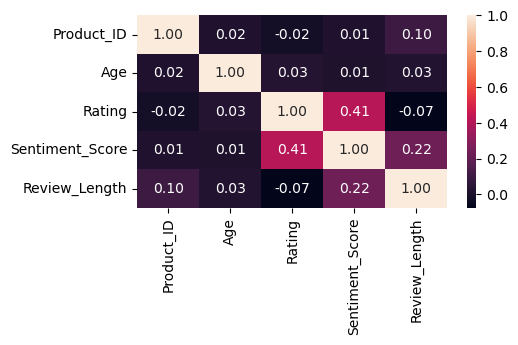

In [151]:
confusion_matrix = df.corr()
plt.figure(figsize=(5, 2.5))
sb.heatmap(confusion_matrix, annot = True, fmt = '.2f')
plt.show()

### Distribution of ratings across dataset

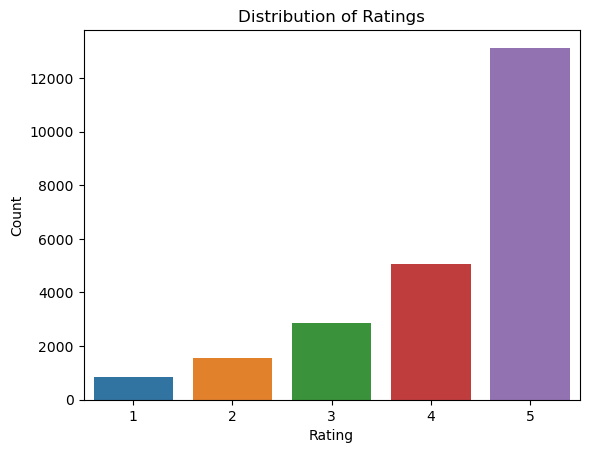

In [152]:
sb.countplot(data=df, x='Rating')
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

### Distribution of Product Type across the dataset

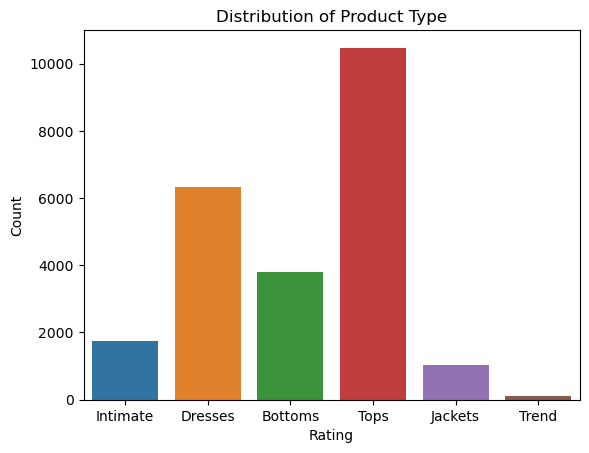

In [153]:
sb.countplot(data=df, x='Type')
plt.title('Distribution of Product Type')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

### Distribution of customer age across the dataset. Most of the customers are in age group 35 to 45

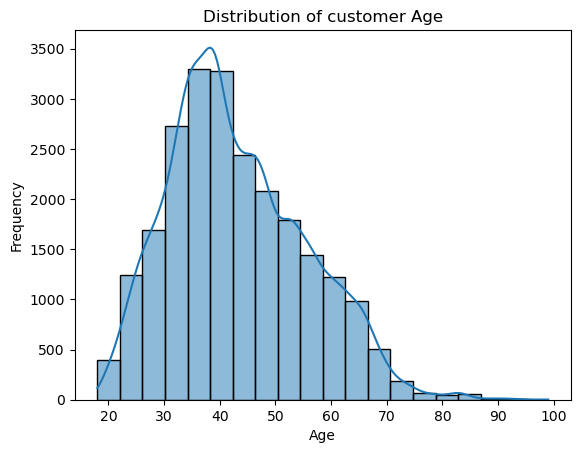

In [154]:
sb.histplot(data=df, x='Age', bins=20, kde=True)
plt.title('Distribution of customer Age')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

### Distribution of review lengths across the dataset. Most of the reviews have length 90 to 110

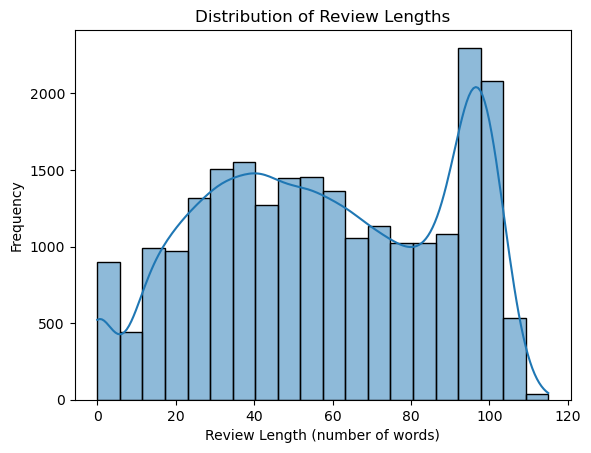

In [155]:
sb.histplot(data=df, x='Review_Length', bins=20, kde=True)
plt.title('Distribution of Review Lengths')
plt.xlabel('Review Length (number of words)')
plt.ylabel('Frequency')
plt.show()

### Finding the most important words as per rating and sentiment

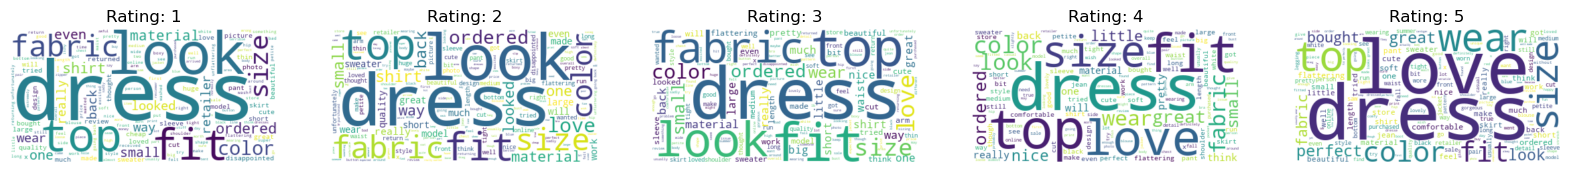

In [156]:
fig, axes = plt.subplots(1, 5, figsize=(20, 5))
temp = df.sort_values(by = 'Rating')
for i, rating in enumerate(temp['Rating'].unique()):
    text = " ".join(review for review in df[df['Rating'] == rating].Text_Review)
    wordcloud = WordCloud(background_color='white').generate(text)
    axes[i].imshow(wordcloud, interpolation='bilinear')
    axes[i].set_title(f'Rating: {rating}')
    axes[i].axis('off')
plt.show()

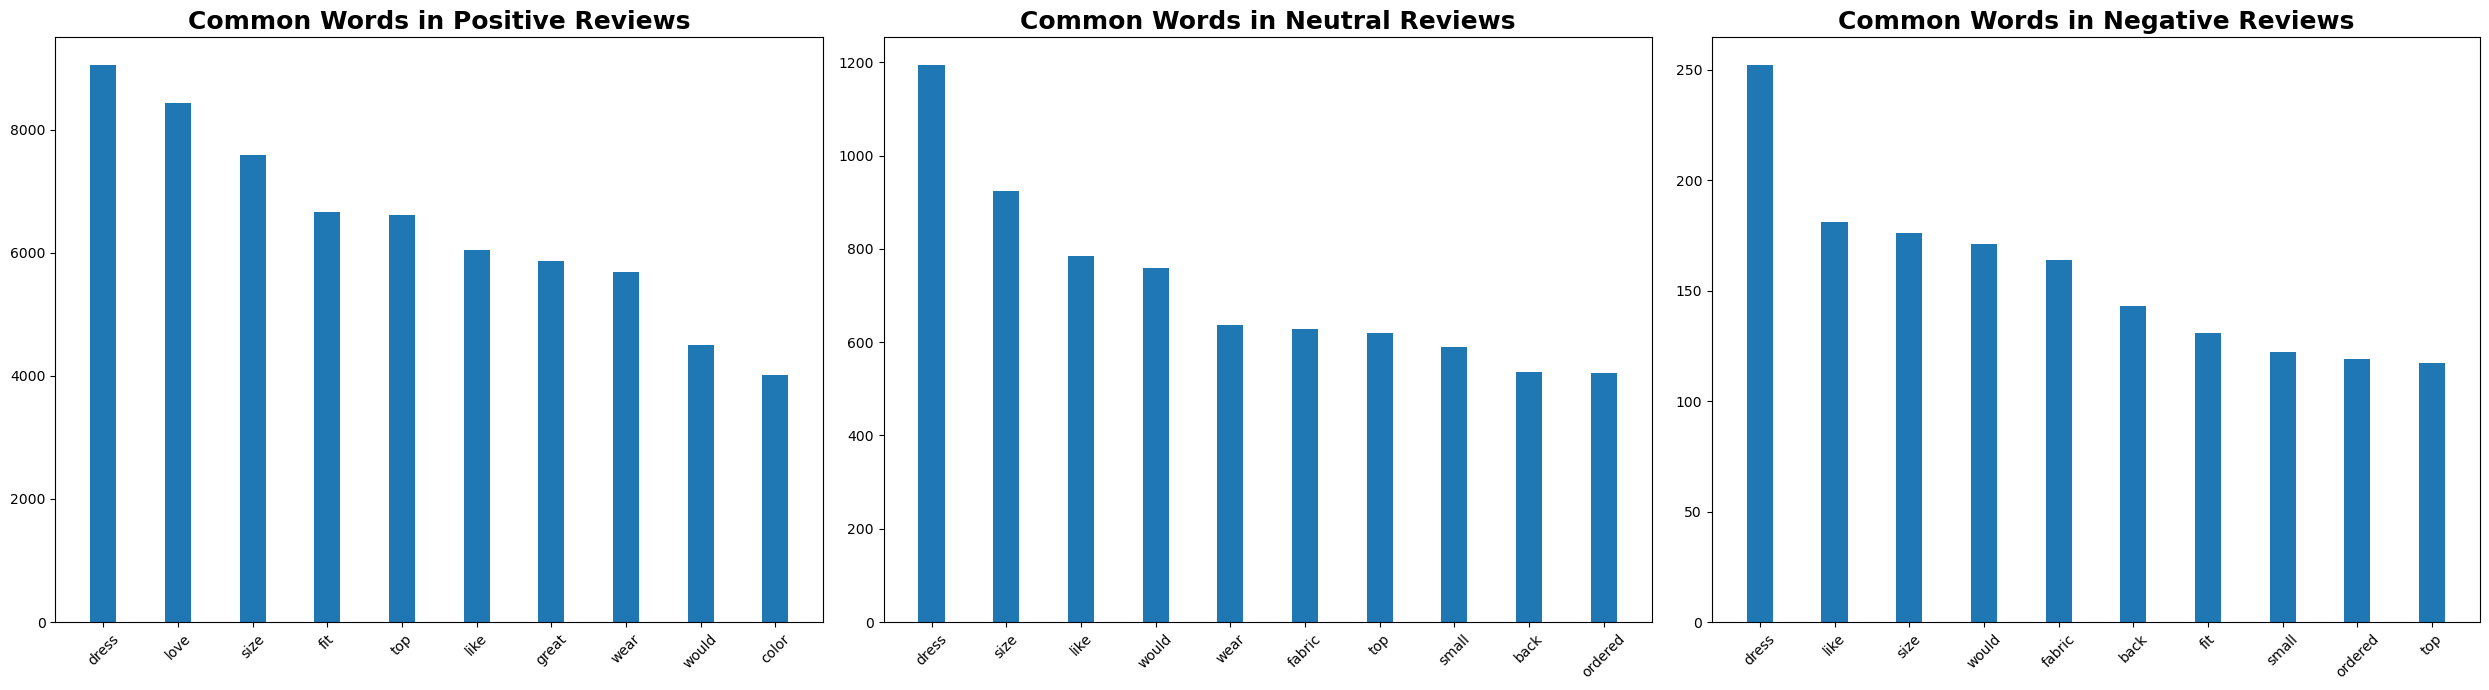

In [157]:
positive_reviews = df[df['Sentiment'] == 'Positive'].Text_Review.tolist()
neutral_reviews = df[df['Sentiment'] == 'Neutral'].Text_Review.tolist()
negative_reviews = df[df['Sentiment'] == 'Negative'].Text_Review.tolist()

stop_words = set(stopwords.words('english'))
def tokenize_and_clean(reviews):
    all_words = []
    for review in reviews:
        words = word_tokenize(review.lower())
        words = [word for word in words if word.isalpha() and word not in stop_words]
        all_words.extend(words)
    return all_words

positive_words = tokenize_and_clean(positive_reviews)
neutral_words = tokenize_and_clean(neutral_reviews)
negative_words = tokenize_and_clean(negative_reviews)

positive_common_words = Counter(positive_words).most_common(10)
neutral_common_words = Counter(neutral_words).most_common(10)
negative_common_words = Counter(negative_words).most_common(10)

words1, counts1 = zip(*positive_common_words)
words2, counts2 = zip(*neutral_common_words)
words3, counts3 = zip(*negative_common_words)

# Create a figure with 1 row and 3 columns of subplots
fig, axes = plt.subplots(1, 3, figsize=(25, 7))

# Plot the first graph
axes[0].bar(words1, counts1, width=0.35)
axes[0].set_title('Common Words in Positive Reviews', fontsize = 18, fontweight = 'bold')
axes[0].set_xticks(range(len(words1)))
axes[0].set_xticklabels(words1, rotation=45)

# Plot the second graph
axes[1].bar(words2, counts2, width=0.35)
axes[1].set_title('Common Words in Neutral Reviews', fontsize = 18, fontweight = 'bold')
axes[1].set_xticks(range(len(words2)))
axes[1].set_xticklabels(words2, rotation=45)

# Plot the third graph
axes[2].bar(words3, counts3, width=0.35)
axes[2].set_title('Common Words in Negative Reviews', fontsize = 18, fontweight = 'bold')
axes[2].set_xticks(range(len(words3)))
axes[2].set_xticklabels(words3, rotation=45)

# Adjust the layout to prevent overlapping
plt.tight_layout()
plt.show()

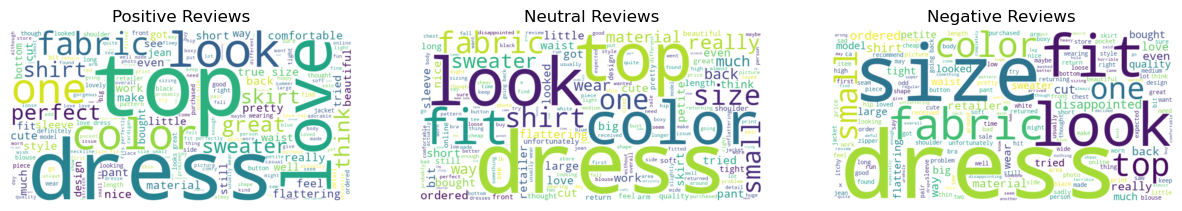

In [158]:
positive_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(" ".join(positive_words))
neutral_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(" ".join(neutral_words))
negative_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(" ".join(negative_words))

fig, axes = plt.subplots(1, 3, figsize=(15, 7))

axes[0].imshow(positive_wordcloud, interpolation='bilinear')
axes[0].set_title('Positive Reviews')
axes[0].axis('off')

axes[1].imshow(neutral_wordcloud, interpolation='bilinear')
axes[1].set_title('Neutral Reviews')
axes[1].axis('off')

axes[2].imshow(negative_wordcloud, interpolation='bilinear')
axes[2].set_title('Negative Reviews')
axes[2].axis('off')

plt.show()

### Distribution of sentiments across product type

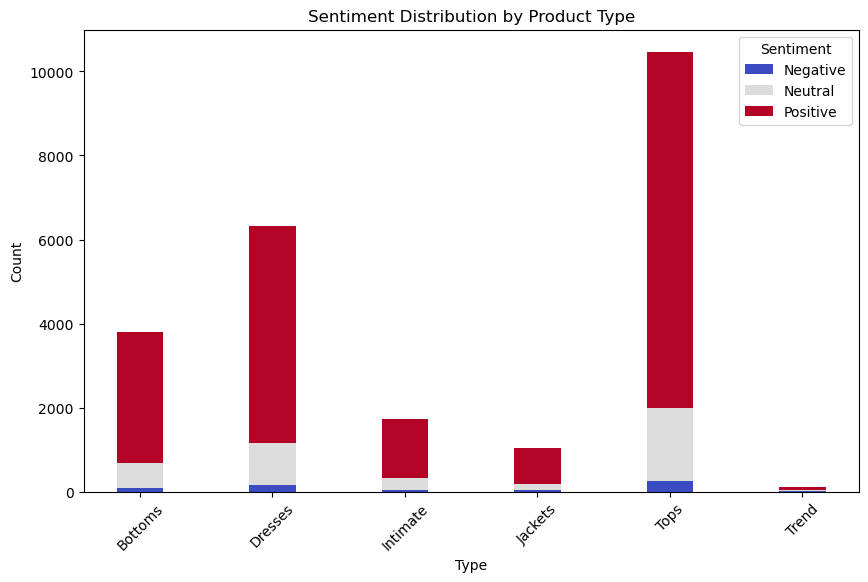

In [159]:
sentiment_by_feature = df.groupby(['Type', 'Sentiment']).size().unstack(fill_value=0)
sentiment_by_feature.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='coolwarm', width = 0.35)
plt.title('Sentiment Distribution by Product Type')
plt.xlabel('Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Sentiment')
plt.show()

### Distinct product ID from each type

In [160]:
t = df.groupby('Type')['Product_ID'].nunique().reset_index().sort_values(by = 'Product_ID', ascending = False)

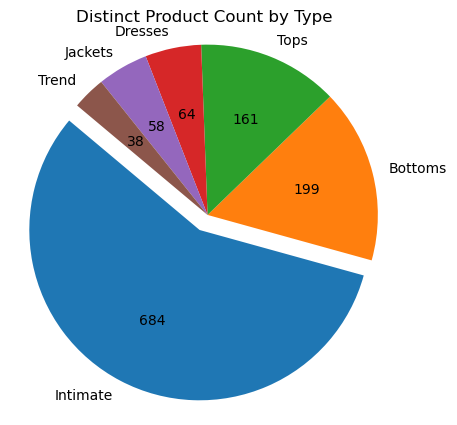

In [161]:
def absolute_value(val):
    a  = np.round(val/100.*t['Product_ID'].sum(), 0)
    return int(a)

explode = [0.1, 0, 0, 0, 0, 0]
plt.figure(figsize=(5, 5))
wedges, texts, autotexts = plt.pie(t['Product_ID'], 
        labels=t['Type'], 
        autopct=absolute_value, 
        startangle=140,
        explode = explode)

for text in texts:
    text.set_fontsize(10)
    
plt.title('Distinct Product Count by Type')
plt.axis('equal')  
plt.show()

### Distinct number of product id pertaining to each rating

In [162]:
t = df.groupby('Product_ID')['Rating'].mean().reset_index().sort_values(by = 'Rating', ascending = False)
t['Rating'] = round(t['Rating']).astype(int)
rating_uniqueProd_map = t.groupby('Rating')['Product_ID'].count().reset_index()

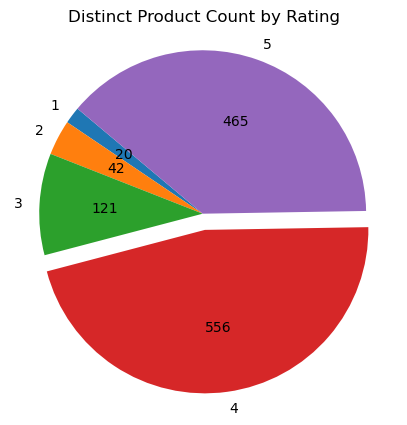

In [163]:
def absolute_value(val):
    a  = np.round(val/100.*rating_uniqueProd_map['Product_ID'].sum(), 0)
    return int(a)

explode = [0, 0, 0, 0.1, 0]
plt.figure(figsize=(5, 5))
wedges, texts, autotexts = plt.pie(rating_uniqueProd_map['Product_ID'], 
        labels=rating_uniqueProd_map['Rating'], 
        autopct=absolute_value, 
        startangle=140,
        explode = explode)

for text in texts:
    text.set_fontsize(10)
    
plt.title('Distinct Product Count by Rating')
plt.axis('equal')  
plt.show()

### 10 most and least sold product ID for each product type

#### Description: Some of the most sold products have lower ratings and vice versa. Can use targeted marketing to sale more of high rated products

In [164]:
def display_top_and_bottom_10(type_of_product):
    filtered_df = df[df['Type'] == type_of_product]

    most_sold_product_df = filtered_df.groupby('Product_ID').agg(
        most_sold_tops=('Product_ID', 'size'),
        meanRating=('Rating', 'mean')
    ).reset_index()

    tops_top10 = most_sold_product_df.sort_values(by='most_sold_tops', ascending=False).head(10)
    tops_top10['meanRating'] = round(tops_top10['meanRating'], 2)
    
    tops_bottom10 = most_sold_product_df.sort_values(by='most_sold_tops', ascending=False).tail(10)
    tops_bottom10['meanRating'] = round(tops_bottom10['meanRating'], 2)
    
    product_ids_most = tops_top10['Product_ID'].tolist()
    most_sold_tops_most = tops_top10['most_sold_tops'].tolist()
    mean_ratings_most = tops_top10['meanRating'].tolist()

    product_ids_least = tops_bottom10['Product_ID'].tolist()
    most_sold_tops_least = tops_bottom10['most_sold_tops'].tolist()
    mean_ratings_least = tops_bottom10['meanRating'].tolist()

    colors = ['red', 'green', 'blue', 'yellow', 'purple', 'orange', 'cyan', 'magenta', 'lime', 'pink']

    bar_width = 0.35

    index_most = range(len(product_ids_most))
    index_least = range(len(product_ids_least))

    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    axes[0].bar(index_most, most_sold_tops_most, bar_width, color=colors, label='Most Sold Tops')

    for i in range(len(product_ids_most)):
        axes[0].text(i, most_sold_tops_most[i] + 0.01, str(mean_ratings_most[i]), ha='center')

    axes[0].set_title('10 Most Sold {0} by Product ID with Mean Rating'.format(type_of_product))
    axes[0].set_xlabel('Product ID')
    axes[0].set_ylabel('Most Sold Tops')
    axes[0].set_xticks(index_most)
    axes[0].set_xticklabels(product_ids_most, rotation='vertical')
    axes[0].legend()

    axes[1].bar(index_least, most_sold_tops_least, bar_width, color=colors, label='Most Sold Tops')

    for i in range(len(product_ids_least)):
        axes[1].text(i, most_sold_tops_least[i] + 0.01, str(mean_ratings_least[i]), ha='center')

    axes[1].set_title('10 Least Sold {0} by Product ID with Mean Rating'.format(type_of_product))
    axes[1].set_xlabel('Product ID')
    axes[1].set_ylabel('Most Sold Tops')
    axes[1].set_xticks(index_least)
    axes[1].set_xticklabels(product_ids_least, rotation='vertical')

    plt.tight_layout()
    plt.show()

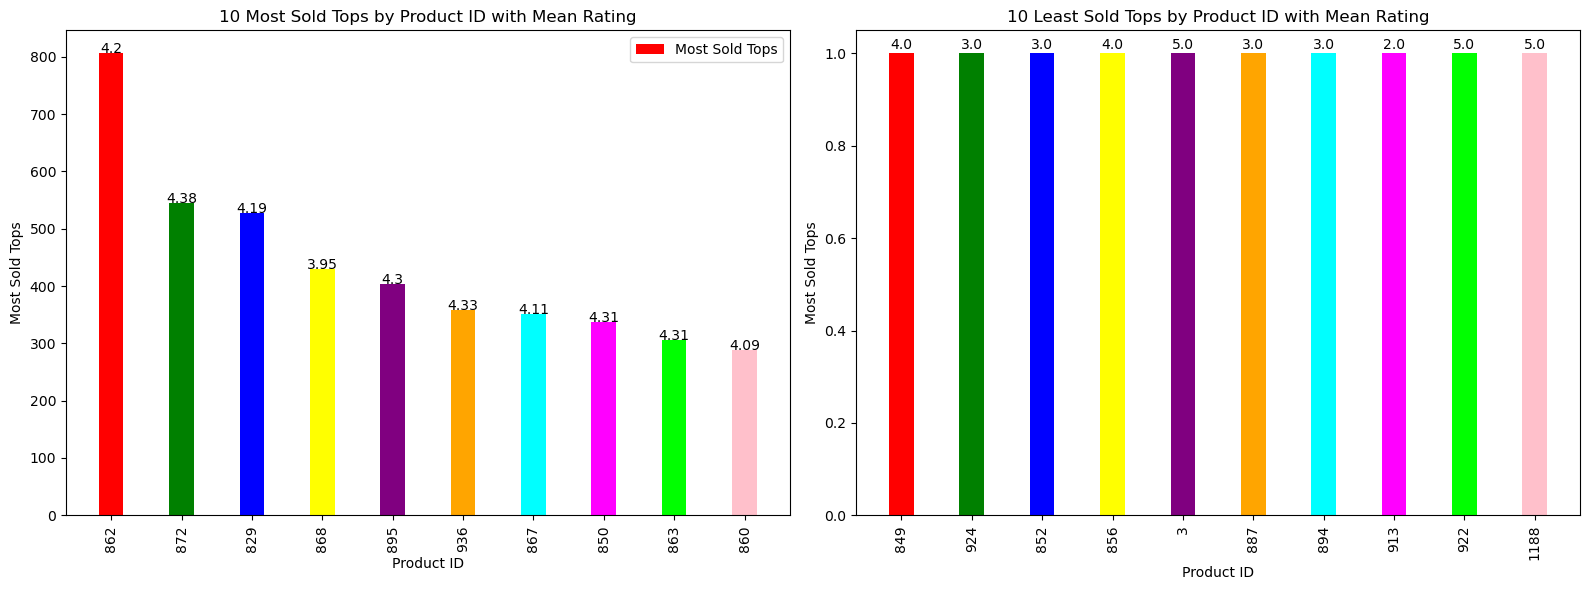

In [165]:
display_top_and_bottom_10('Tops')

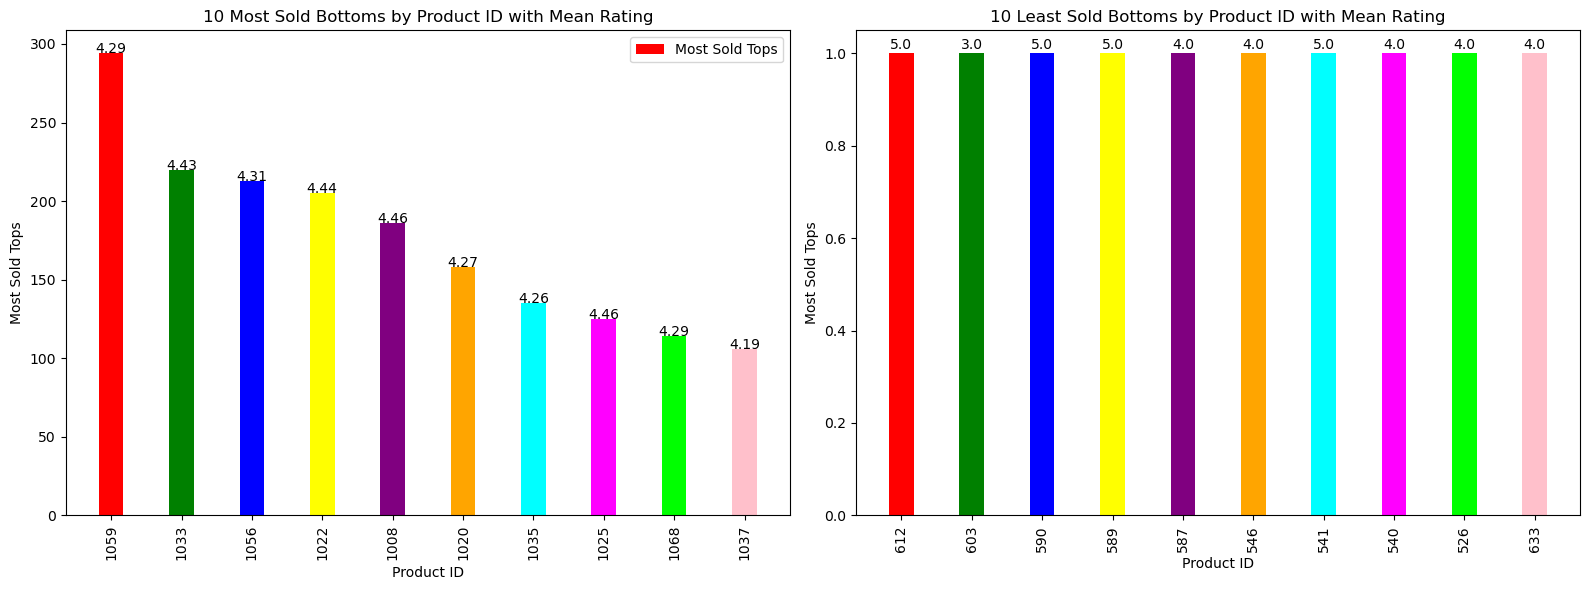

In [166]:
display_top_and_bottom_10('Bottoms')

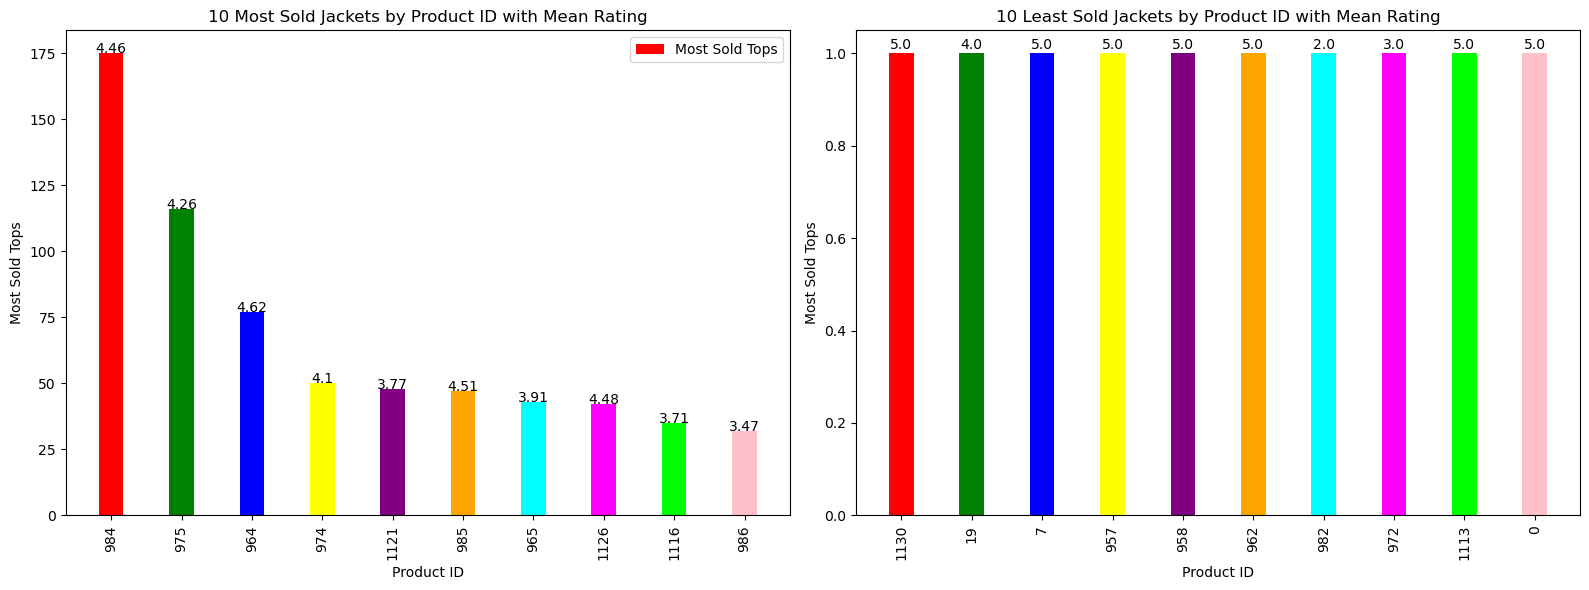

In [167]:
display_top_and_bottom_10('Jackets')

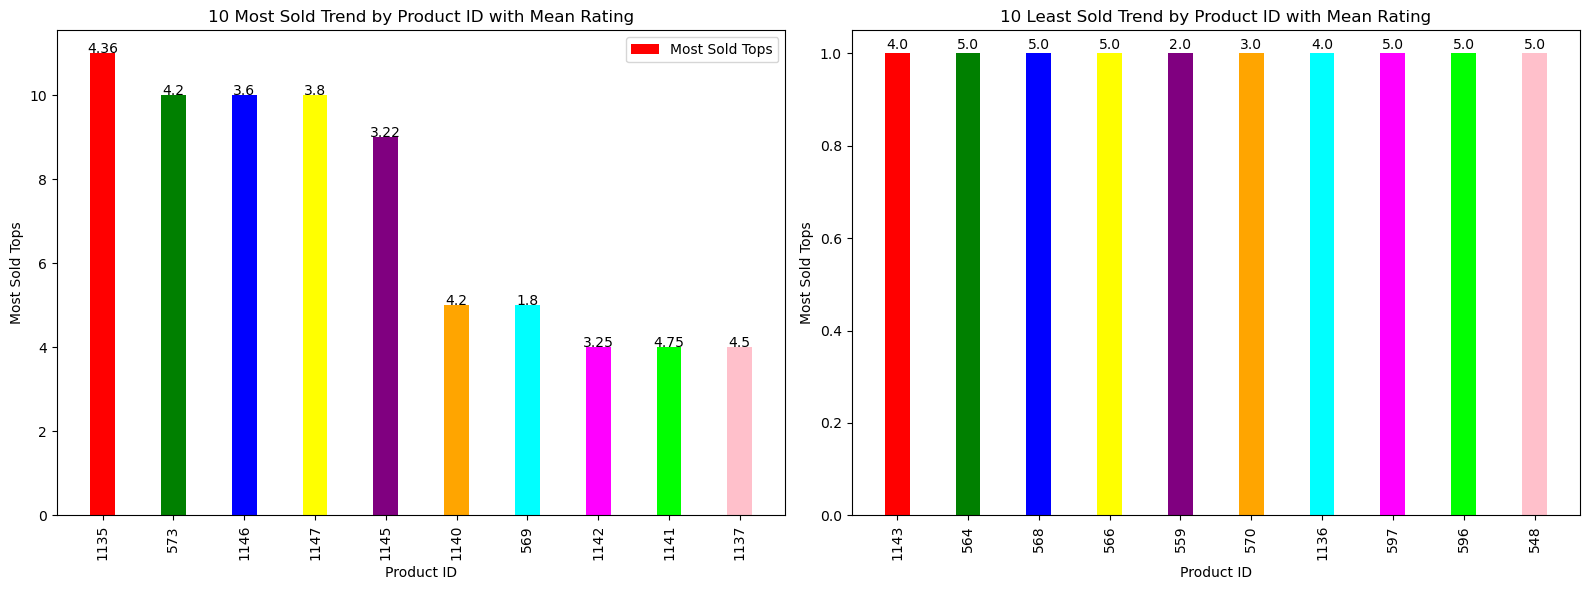

In [168]:
display_top_and_bottom_10('Trend')

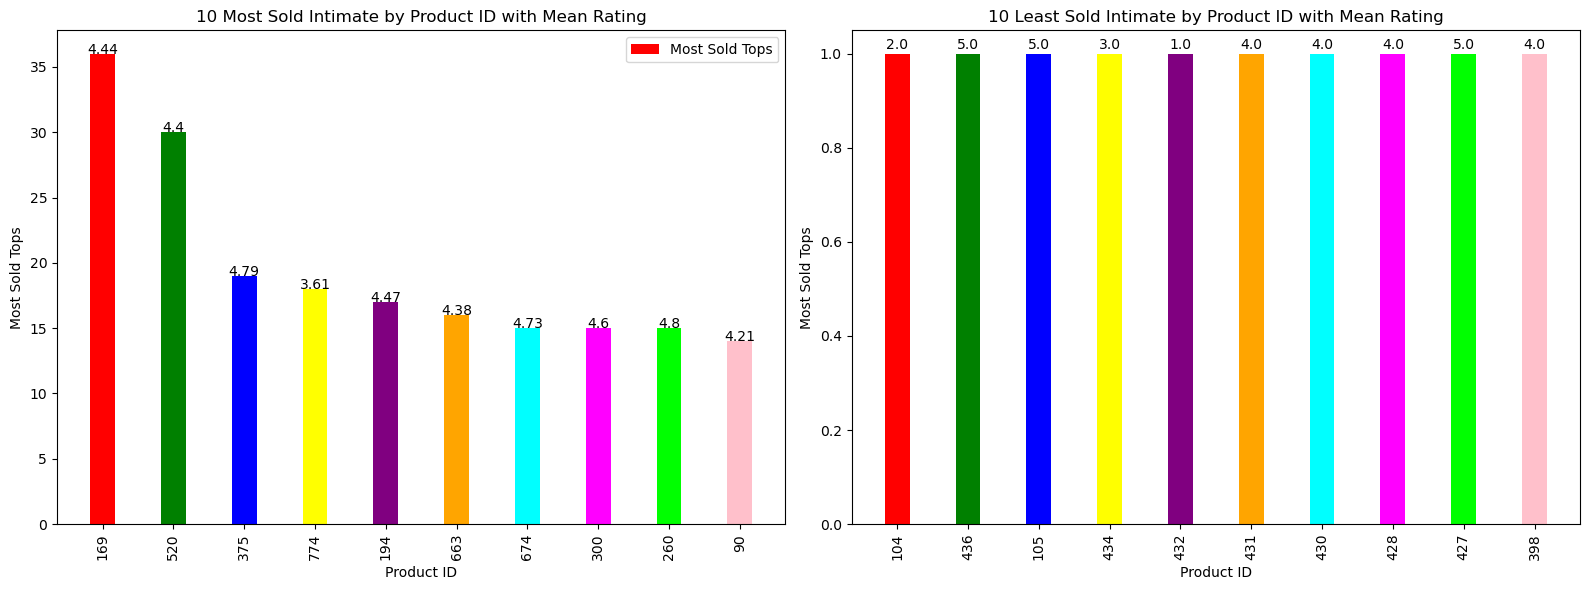

In [169]:
display_top_and_bottom_10('Intimate')

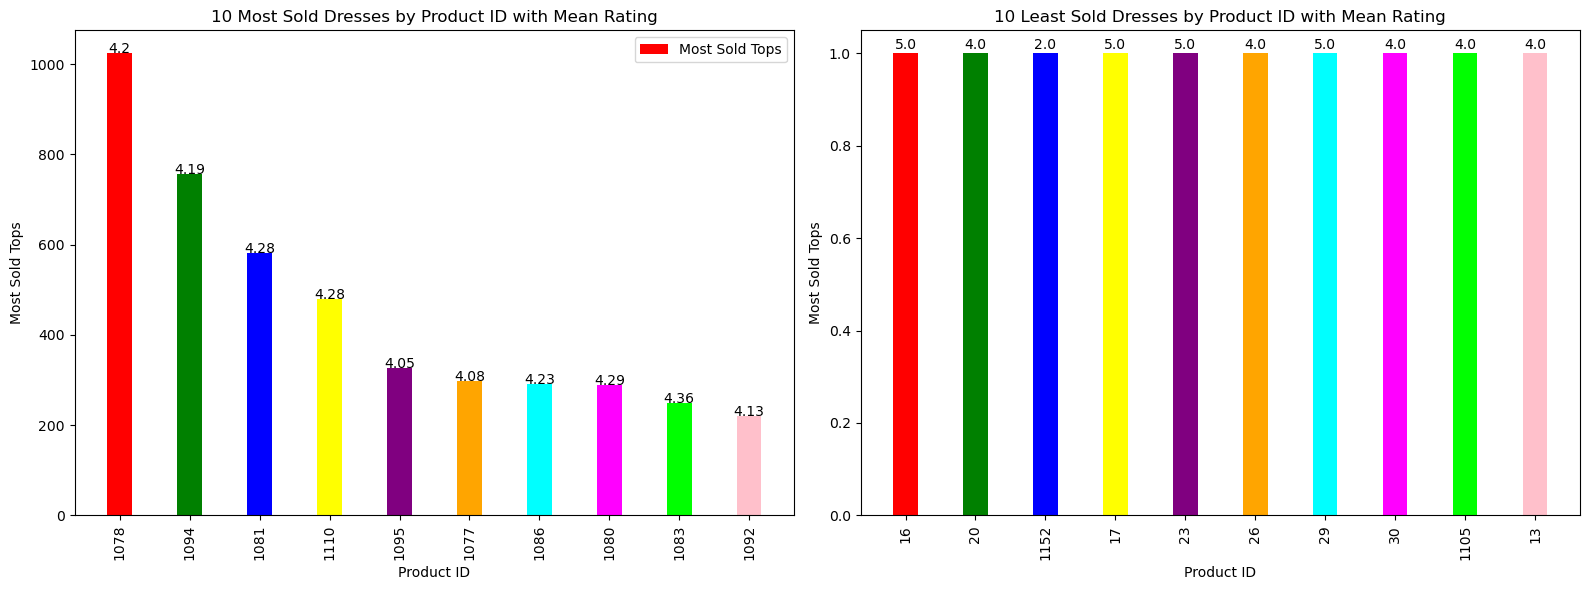

In [170]:
display_top_and_bottom_10('Dresses')

### Finding Type most in demand by age group

### People in the age group [35 - 44] widely use the retail services. Most of the customers buy Tops.

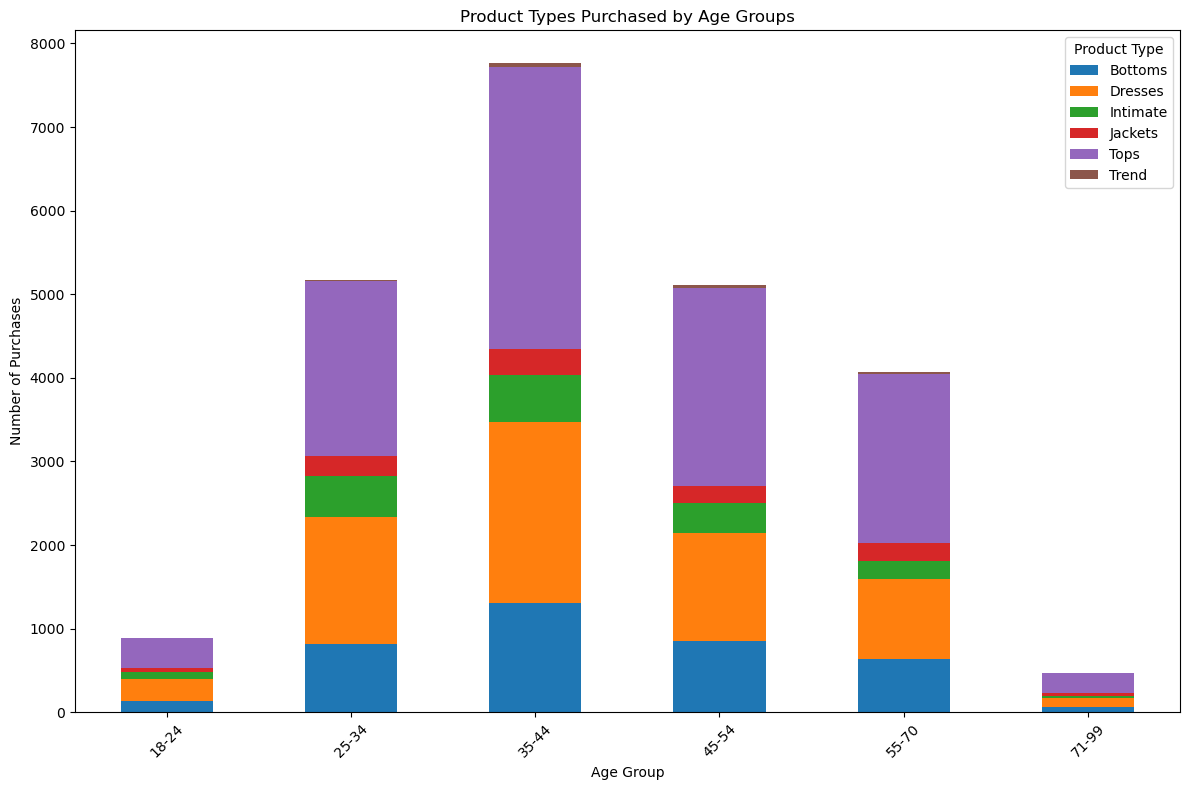

In [171]:
age_bins = [18, 25, 35, 45, 55, 70, 99]
age_labels = ['18-24', '25-34', '35-44', '45-54', '55-70', '71-99']
df['Age Group'] = pd.cut(df['Age'], bins=age_bins, labels=age_labels, right=False)

age_type_counts = df.groupby(['Age Group', 'Type']).size().unstack().fillna(0)

age_type_counts.plot(kind='bar', stacked=True, figsize=(12, 8))

plt.title('Product Types Purchased by Age Groups')
plt.xlabel('Age Group')
plt.ylabel('Number of Purchases')
plt.legend(title='Product Type')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Distribution of least and most ratings per age-group

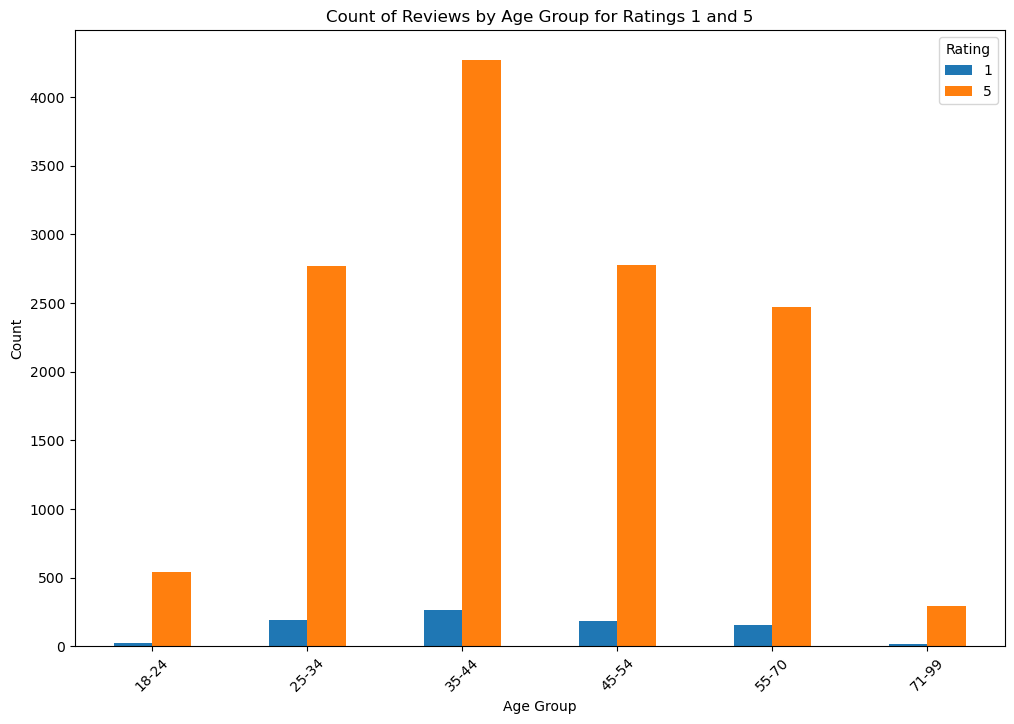

In [172]:
df_filtered = df[df['Rating'].isin([1, 5])]
age_rating_counts = df_filtered.groupby(['Age Group', 'Rating']).size().unstack(fill_value=0)
age_rating_counts.plot(kind='bar', figsize=(12, 8))
plt.title('Count of Reviews by Age Group for Ratings 1 and 5')
plt.xlabel('Age Group')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Rating')
plt.show()

### Finding average sentiment by age group

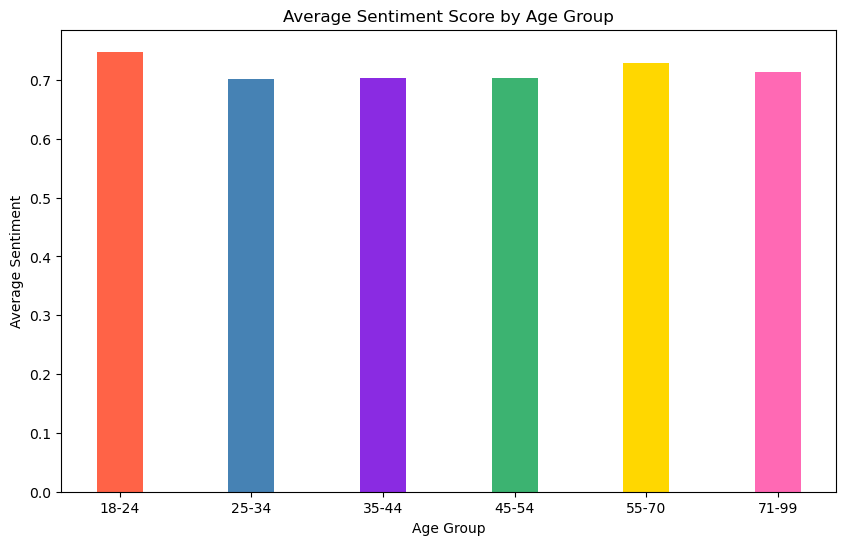

In [173]:
agewise_sentiment = df.groupby('Age Group')['Sentiment_Score'].mean().reset_index(name = 'Average_sentiment')

plt.figure(figsize=(10, 6))
colors = ['#FF6347', '#4682B4', '#8A2BE2', '#3CB371', '#FFD700', '#FF69B4']
plt.bar(agewise_sentiment['Age Group'], agewise_sentiment['Average_sentiment'], color=colors, width = 0.35)
plt.title('Average Sentiment Score by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Average Sentiment')

plt.show()

### Demand Score - > Ratio of Total sold product ID / unique product ID. <br> In case of Intimate there are 686 unique Product ID and total products sold are 1735. The ratio 1735 / 686 is pretty low

### In case of Tops, there are 160 unique Product ID and sold are 10468.The ratio 10468 / 160 is pretty high

### Need to sell more of "Intimate" type because it has more variety compared to "Tops"

In [174]:
grouped_df = df.groupby('Type').agg(
    unique_productID=('Product_ID', 'nunique'),
    total_productID=('Product_ID', 'count')
).reset_index()

grouped_df['Demand_score'] = grouped_df['total_productID'] / grouped_df['unique_productID'] 

result_df = grouped_df[['Type', 'Demand_score']]

result_df = result_df.sort_values(by = 'Demand_score', ascending = False)

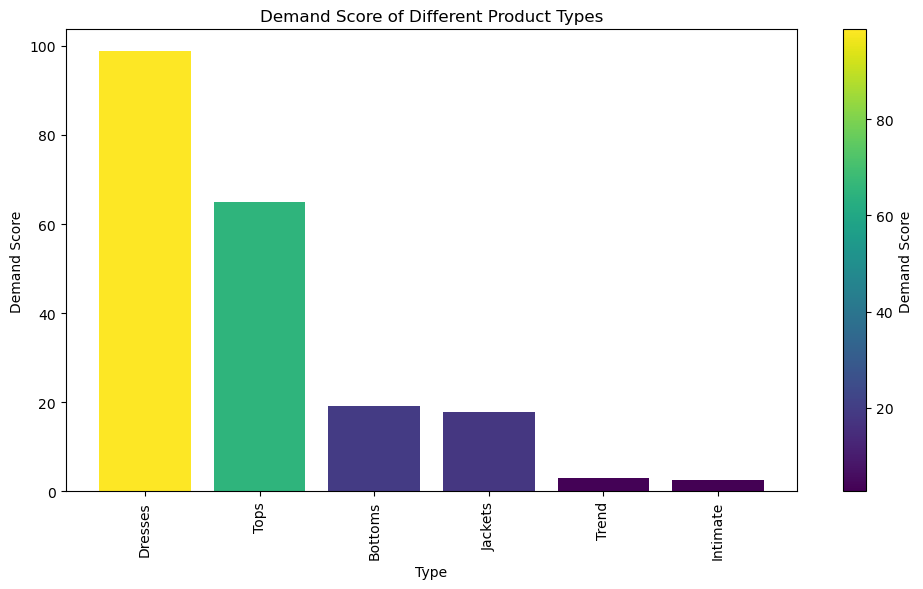

In [175]:
types = result_df['Type']
demand_scores = result_df['Demand_score']

norm = plt.Normalize(min(demand_scores), max(demand_scores))
colors = cm.viridis(norm(demand_scores))

plt.figure(figsize=(10, 6))
bars = plt.bar(types, demand_scores, color=colors)

plt.title('Demand Score of Different Product Types')
plt.xlabel('Type')
plt.ylabel('Demand Score')

sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm)
cbar.set_label('Demand Score')

plt.xticks(rotation='vertical')
plt.tight_layout()
plt.show()

### Distribution of least and most ratings per product type

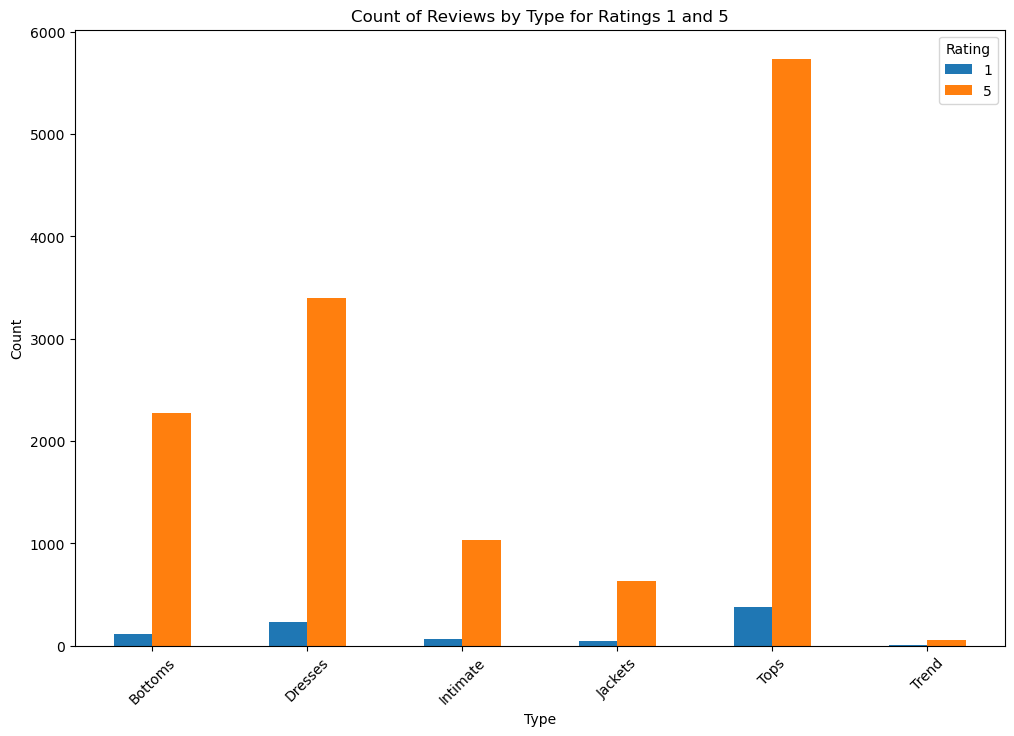

In [176]:
df_filtered = df[df['Rating'].isin([1, 5])]
type_rating_counts = df_filtered.groupby(['Type', 'Rating']).size().unstack(fill_value=0)
type_rating_counts.plot(kind='bar', figsize=(12, 8))
plt.title('Count of Reviews by Type for Ratings 1 and 5')
plt.xlabel('Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Rating')
plt.show()

### Average review length per product type

### Trend type has highest average review length which indicates most user engagement

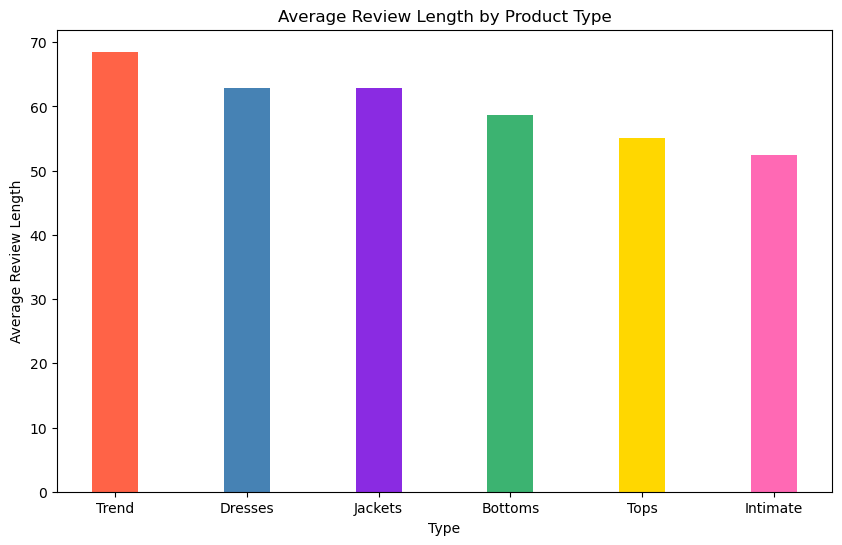

In [177]:
agewise_reviewlength = df.groupby('Type')['Review_Length'].mean().reset_index(name = 'Average_review_length').sort_values(by = 'Average_review_length', ascending = False)
plt.figure(figsize=(10, 6))
colors = ['#FF6347', '#4682B4', '#8A2BE2', '#3CB371', '#FFD700', '#FF69B4']
plt.bar(agewise_reviewlength['Type'], agewise_reviewlength['Average_review_length'], color=colors, width = 0.35)
plt.title('Average Review Length by Product Type')
plt.xlabel('Type')
plt.ylabel('Average Review Length')
plt.show()

### Pain Points:

1. **Negative Reviews**:
   - **Common Words**: Words such as "unfortunately," "problem," "disappointed," "loose," and "return" frequently appear in negative reviews, indicating issues with product quality, fit, and customer satisfaction.
   - **Product Quality Issues**: The term "loose" suggests sizing or fitting problems, while "problem" and "disappointed" indicate general dissatisfaction, which can impact overall brand perception.
   

2. **Demand Disparity**:
   - **Intimate Category**: Despite having the most variety with 686 unique product IDs, sales are significantly low at 1735 units, indicating either a mismatch between the variety offered and customer preference or possible marketing/awareness issues.


3. **Low Ratings on High-Selling Products**:
   - Some of the most sold products have lower ratings, indicating that high sales do not necessarily equate to high customer satisfaction. This could lead to long-term customer attrition if not addressed.

### What's Working:

1. **High Ratings**:
   - Most products are rated 5 stars, indicating overall customer satisfaction with the majority of the products.


2. **Top-Selling Category**:
   - Tops are the most sold items, suggesting strong customer preference and possibly good design and marketing strategies in this category.


3. **Positive Reviews**:
   - **Common Words**: Words like "great," "love," "flattered," "beautiful," and "cute" in positive reviews highlight the aspects of the products that customers appreciate, such as aesthetics and fit.


4. **Unique Designs**:
   - Most unique product IDs have high ratings (4* and 5*), suggesting that customers appreciate the unique designs offered.

### Not Working:

1. **Engagement vs. Sales in Trend**:
   - Although the Trend category has the highest average review length, indicating high user engagement, it is also the least sold category. This mismatch suggests that while customers are interested and engaged, the final purchase rate is low, possibly due to issues like pricing, availability, or relevance.


2. **Low Demand for Intimate Products**:
   - Despite having the most variety, the Intimate category shows the lowest demand score, indicating a significant gap between product offerings and customer needs or awareness.


3. **Targeted Marketing Opportunities**:
   - There is potential to leverage targeted marketing to boost sales of high-rated products that are not currently top sellers. This indicates a need for better alignment of marketing strategies with product ratings and customer satisfaction.

### Actionable Insights:

1. **Improve Quality Control**: Address recurring issues mentioned in negative reviews, such as sizing and product defects, to enhance customer satisfaction and reduce return rates.


2. **Optimize Product Offering in Intimate Category**: Reevaluate the product range in the Intimate category to better align with customer preferences, possibly by reducing less popular items and focusing on top-performing ones.


3. **Leverage Positive Reviews for Marketing**: Use the positive aspects highlighted in reviews to market top-rated products more effectively, emphasizing what customers love about these items.


4. **Analyze Engagement in Trend Category**: Investigate why high engagement in the Trend category is not translating into sales and adjust strategies accordingly, such as pricing adjustments, promotional offers, or product redesigns.


5. **Targeted Marketing for High-Rated Products**: Implement marketing campaigns focused on high-rated but lower-selling products to improve their visibility and sales, ensuring that quality products receive the attention they deserve.